In [1]:
import os
from collections import OrderedDict
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import json
import reprlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



C:\Users\Lenovo\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
# Membaca data yang sudah dibersihkan dari karakter yang tidak diperlukan serta dari daftar kata tak baku dan stop words
os.chdir("Output")
base = "data_hasil_cleansing - filterisasi-penghilangan duplikasi data-slangSastrawi-stopWordSastrawati.txt"

In [3]:
#menghapus duplikat data

input_stream = open(base, "r", encoding="'utf8'")
text = input_stream.readlines()
input_stream.close()
print("before:", len(text))

# menghapus duplikasi kalimat dengan mengonversinya ke 'ordered dictionary'
newtext = list(OrderedDict.fromkeys(text))
print("after:", len(newtext))

before: 12990
after: 12244


In [4]:
print(text[:2],)
print(newtext[:2])

['ikn indonesia maju ikn negeri\n', 'gubernur pindah ibukota dorong turun senjang\n']
['ikn indonesia maju ikn negeri\n', 'gubernur pindah ibukota dorong turun senjang\n']


In [5]:
# Menyimpan teks yang sudah dibersihkan ke file
output = os.path.splitext(base)[0]+'-dup.txt'
with open(output, 'w') as f:
    for line in newtext:
        f.write(str(line))

In [6]:
# data yang digunakan hanya data, tanpa kolom label
Corpus = pd.read_csv(output, encoding='latin-1', header=None, names=['text'], usecols=['text'], dtype=str)

In [7]:
Corpus['text']

0                            ikn indonesia maju ikn negeri
1             gubernur pindah ibukota dorong turun senjang
2                     indonesia negara nusantara ibukotaku
3                    indonesia negara nusantara ibukota ku
4        pindah ibukota cabut sejarah bentuk nkri negar...
                               ...                        
12238    gera jokowi priode belah china indonesia ibuko...
12239    gambar animsinya kyk anak kuliah arsitektur sm...
12240    wakil ketua dprd rany mauliani salah upaya tah...
12241    ngapain kereta cepat bandung klo thoh ibukota ...
12242    bangun ikn nusantara perhati sejahtera duduk l...
Name: text, Length: 12243, dtype: object

# #Pelabelan dengan InSet dan sentistrength_id

In [8]:
# Memanfaatkan nltk VADER untuk menggunakan leksikon kustom
sia1A, sia1B, sia2 = SentimentIntensityAnalyzer(), SentimentIntensityAnalyzer(), SentimentIntensityAnalyzer()
# membersihkan leksikon VADER default
sia1A.lexicon.clear()
sia1B.lexicon.clear()
sia2.lexicon.clear()

# Membaca leksikon InSet
# Leksikon InSet lexicon dibagi menjadi dua, yakni polaritas negatif dan polaritas positif;
# kita akan menggunakan nilai compound saja untuk memberi label pada suatu kalimat
with open('../Dictionary/inset/_json_inset-neg.txt') as f:
    data1A = f.read()
with open('../Dictionary/inset/_json_inset-pos.txt') as f:
    data1B = f.read()
       
# Membaca leksikon sentiwords_id
with open('../Dictionary/sentistrength_id/_json_sentiwords_id.txt') as f:
    data2 = f.read()


# Mengubah leksikon sebagai dictionary
insetNeg = json.loads(data1A)
insetPos = json.loads(data1B)
senti = json.loads(data2)

# Update leksikon VADER yang sudah 'dimodifikasi'
sia1A.lexicon.update(insetNeg)
sia1B.lexicon.update(insetPos)
sia2.lexicon.update(senti)

print(reprlib.repr(sia1A.lexicon))
print(reprlib.repr(sia1B.lexicon))
print(reprlib.repr(sia2.lexicon))

{'(barang) bekas': -4, '(olahraga) bokser': -5, '(tua) uzur': -3, 'Anda': -4, ...}
{'(hujan) gerimis': 1, '(warna) dadu': 3, 'Ahad': 3, 'Sri paduka': 4, ...}
{'abadi': 5, 'absen': -3, 'abu-abu': -1, 'acuh': 4, ...}


### Contoh: menghitung skor polaritas dari suatu kalimat

In [9]:
sample = "bangun ikn nusantara dampak positif utama tingkat ekonomi indonesia suara sumatera utara"
print("insetNeg: ", sia1A.polarity_scores(sample))
print("insetPos: ", sia1B.polarity_scores(sample))
print("insetCpdSum: 'compound':", sia1A.polarity_scores(sample)["compound"] + sia1B.polarity_scores(sample)["compound"])

print("senti\t: ", sia2.polarity_scores(sample))

insetNeg:  {'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'compound': -0.7184}
insetPos:  {'neg': 0.0, 'neu': 0.474, 'pos': 0.526, 'compound': 0.875}
insetCpdSum: 'compound': 0.15659999999999996
senti	:  {'neg': 0.0, 'neu': 0.688, 'pos': 0.312, 'compound': 0.7184}


### Fungsi untuk mengklasifikasikan kalimat sebagai negatif/positif berdasarkan nilai compound

In [10]:
def is_positive_inset(tweet: str) -> bool:
    """True if tweet has positive compound sentiment, False otherwise."""
    return sia1A.polarity_scores(tweet)["compound"] + sia1B.polarity_scores(tweet)["compound"] > 0

def is_positive_senti(tweet: str) -> bool:
    """True if tweet has positive compound sentiment, False otherwise."""
    return sia2.polarity_scores(tweet)["compound"] > 0

In [11]:
tweets = Corpus["text"]

# Menulis hasil klasifikasi label untuk setiap kalimat berdasarkan nilai compound dari insetNeg dan insetPos
output = os.path.splitext(base)[0]+'-lb-inset.txt'
with open(output, 'w') as f:
    for tweet in tweets:
        if is_positive_inset(tweet) == True:
            label = "pos"
        else:
            label = "neg"
        f.write(str(label+'\n'))

# Menulis hasil klasifikasi label untuk setiap kalimat berdasarkan nilai compound dari SentiStrength
output = os.path.splitext(base)[0]+'-lb-senti.txt'
with open(output, 'w') as f:
    for tweet in tweets:
        if is_positive_senti(tweet) == True:
            label = "pos"
        else:
            label = "neg"
        f.write(str(label+'\n'))

# Jumlah Data: Sebelum & Sesudah Pra-processing

In [4]:
# Pastikan untuk mengganti path dengan absolute path direktorimu jika baris berikut dijalankan ulang, atau restart kernel.
os.chdir('../Dataset')
# menentukan lokasi data awal yang memuat kelas kata negatif dan positif
base1 = 'data hasil crawling juni-september.csv'
LB = pd.read_csv(base1, header=None, dtype=str)

os.chdir('../output')
# data setelah prapengolahan
base2 = 'data_hasil_cleansing - filterisasi-penghilangan duplikasi data-slangSastrawi-stopWordSastrawati-lb-senti.txt'
Lb = pd.read_csv(base2, header=None, dtype=str)

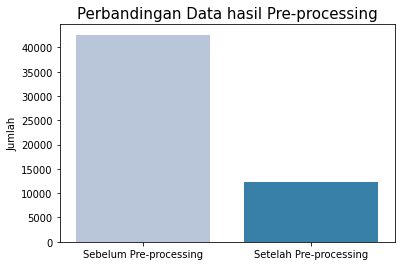

In [6]:
vol = [['Sebelum Pre-processing', len(LB)],
       ['Setelah Pre-processing', len(Lb)]]

df = pd.DataFrame(vol, columns=['dt_type', 'dt_vol'])

sns.set_palette('PuBu',2)
ax = sns.barplot(data=df.reset_index(), x='dt_type', y='dt_vol')
ax.set_ylabel('Jumlah')
ax.set_xlabel('')
ax.set_title('Perbandingan Data hasil Pre-processing', fontsize=15)
ax.yaxis.set_ticks(np.arange(0, 45000, 5000))

# plt.savefig('plot1-data_volume.png')
plt.show()

In [23]:
len(LB) 


42608

# Distribusi Kelas Negatif & Positif

In [14]:
lb_inset = 'data_hasil_cleansing - filterisasi-penghilangan duplikasi data-slangSastrawi-stopWordSastrawati-lb-inset.txt'
lb_senti = 'data_hasil_cleansing - filterisasi-penghilangan duplikasi data-slangSastrawi-stopWordSastrawati-lb-senti.txt'

#x0 = pd.read_csv(lb_actual, header=None,names=['text'], usecols=['label'])
x1 = pd.read_csv(lb_inset, header=None, names=['label'])
x2 = pd.read_csv(lb_senti, header=None, names=['label'])


df = pd.DataFrame()
df.insert(0, 'InSet', x1['label'])
df.insert(1, 'sentistrength_id', x2['label'])
#
print(df)

      InSet sentistrength_id
0       neg              pos
1       neg              neg
2       neg              neg
3       neg              neg
4       neg              neg
...     ...              ...
12238   neg              neg
12239   pos              neg
12240   neg              neg
12241   neg              pos
12242   neg              neg

[12243 rows x 2 columns]


In [15]:
neg1 = df['InSet'].str.count('neg').sum()
pos1 = df['InSet'].str.count('pos').sum()
sum1 = neg1+pos1

neg2 = df['sentistrength_id'].str.count('neg').sum()
pos2 = df['sentistrength_id'].str.count('pos').sum()
sum2 = neg2+pos2

print('negatives:',neg1,', positives:',pos1,', total:',sum1, '\t| inSet')
print('negatives:',neg2,', positives:',pos2,', total:',sum2, '\t| senti')

print('{:.2f}'.format(neg1/sum1*100),':', '{:.2f}'.format(pos1/sum1*100), '\t| inSet')
print('{:.2f}'.format(neg2/sum2*100),':', '{:.2f}'.format(pos2/sum2*100), '\t| senti')

negatives: 4981 , positives: 7262 , total: 12243 	| inSet
negatives: 5053 , positives: 7190 , total: 12243 	| senti
40.68 : 59.32 	| inSet
41.27 : 58.73 	| senti


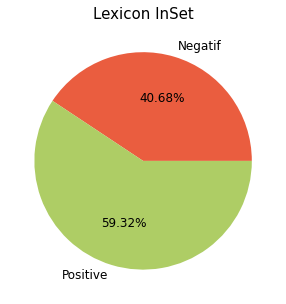

In [41]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Negatif', 'Positive'
sizes = [40.68, 59.32]
colors = ('#EA5D3F', '#AECD65')

fig = plt.figure(figsize=(5,5))
ax = plt.axes()
ax.pie(sizes, labels = labels, autopct='%.2f%%', colors=colors, textprops={'fontsize': 12})
ax.set_title('Lexicon InSet', fontsize=15)
plt.show()

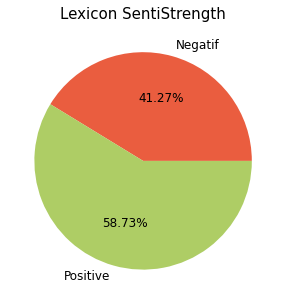

In [46]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Negatif', 'Positive'
sizes = [41.27, 58.73]
colors = ('#EA5D3F', '#AECD65')

fig = plt.figure(figsize=(5,5))
ax = plt.axes()
ax.pie(sizes, labels = labels, autopct='%.2f%%', colors=colors,  textprops={'fontsize': 12})
ax.set_title('Lexicon SentiStrength', fontsize=15)
plt.show()

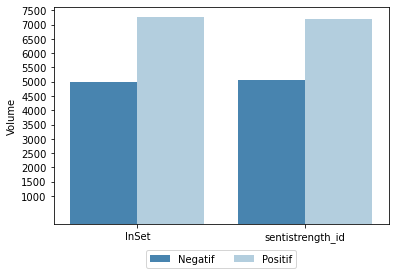

In [16]:
sns.set_palette('Blues_r', 2)
ax = sns.countplot(x='variable', hue='value', data=pd.melt(df))

ax.set_ylabel('Volume')
ax.set_xlabel('')
ax.legend().set_title('')
ax.yaxis.set_ticks(np.arange(1000, 8000, 500))
lgd = ax.legend(['Negatif', 'Positif'], loc='lower center', bbox_to_anchor=(0.5,-0.2), borderaxespad=0., ncol=2)

## *Catatan: bbox_extra_artists harus berupa iterasi
# plt.savefig('plot2-label_class_distribution.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [17]:
# Python program to explain os.getcwd() method
		
# importing os module
import os
	
# Get the current working
# directory (CWD)
cwd = os.getcwd()
	
# Print the current working
# directory (CWD)
print("Current working directory:", cwd)

Current working directory: C:\Users\Lenovo\Documents\python\Sentiment Analysis\output
